# Biomedical QA classification using PubMedBERT

In [ ]:
# --- Load Dataset ---
from datasets import load_dataset
import pandas as pd

dataset_labeled = load_dataset("qiaojin/PubMedQA", 'pqa_labeled')
dataset_unlabeled = load_dataset("qiaojin/PubMedQA", 'pqa_unlabeled')
dataset_artificial = load_dataset('qiaojin/PubMedQA', 'pqa_artificial')

In [ ]:
df_labeled = pd.DataFrame(dataset_labeled['train'])
df_unlabeled = pd.DataFrame(dataset_unlabeled['train'])
df_artificial = pd.DataFrame(dataset_artificial['train'])

In [ ]:
# --- Preprocessing ---
df_labeled = df_labeled[df_labeled['final_decision'] != "maybe"]

label_map = {'yes': 0, 'no': 1}
df_labeled['label'] = df_labeled['final_decision'].map(label_map)
df_artificial['label'] = df_artificial['final_decision'].map(label_map)

df_labeled_final = df_labeled[['question', 'long_answer', 'label']]
df_artificial_final = df_artificial[['question', 'long_answer', 'label']]

In [ ]:
# Balance Artificial Dataset (Downsampling)
df_artificial_final = df_artificial_final.groupby('label').sample(
    n=min(df_artificial_final['label'].value_counts()), random_state=42
)
df_artificial_final = df_artificial_final.sample(frac=1, random_state=42)

In [ ]:
# Train/Validation Split
from sklearn.model_selection import train_test_split

df_train_split, df_val_split = train_test_split(
    df_artificial_final,
    test_size=0.1,
    random_state=42,
    stratify=df_artificial_final['label']
)

df_test = df_labeled_final

## Tokenization

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained('microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract')

def encode_data(tokenizer, questions, contexts, max_length):
    encoding = tokenizer(
        questions,
        contexts,
        truncation=True,
        padding='max_length',
        max_length=max_length,
        return_tensors='pt'
    )
    return encoding['input_ids'], encoding['attention_mask'], encoding['token_type_ids']

# Encode Train
input_ids, attention_mask, token_type_ids = encode_data(
    tokenizer,
    df_train_split['question'].tolist(),
    df_train_split['long_answer'].tolist(),
    max_length=512
)

# Encode Validation
input_ids_val, attention_mask_val, token_type_ids_val = encode_data(
    tokenizer,
    df_val_split['question'].tolist(),
    df_val_split['long_answer'].tolist(),
    max_length=512
)


## Training PubMedBERT

In [ ]:
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset

model = AutoModelForSequenceClassification.from_pretrained(
    'microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract',
    num_labels=2
)

# Prepare HuggingFace datasets
train_ds = Dataset.from_dict({
    'input_ids': input_ids.tolist(),
    'attention_mask': attention_mask.tolist(),
    'token_type_ids': token_type_ids.tolist(),
    'labels': df_train_split['label'].tolist()
})

val_ds = Dataset.from_dict({
    'input_ids': input_ids_val.tolist(),
    'attention_mask': attention_mask_val.tolist(),
    'token_type_ids': token_type_ids_val.tolist(),
    'labels': df_val_split['label'].tolist()
})

training_args = TrainingArguments(
    output_dir='./results_pubmedbert',
    num_train_epochs=1,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    gradient_accumulation_steps=4,
    warmup_steps=100,
    weight_decay=0.01,
    logging_dir='./logs_pubmedbert',
    logging_steps=100,
    save_strategy="epoch",
    metric_for_best_model="eval_loss",
    fp16=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
)

trainer.train()

## Testing

In [ ]:
input_ids_test, attention_mask_test, token_type_ids_test = encode_data(
    tokenizer,
    df_test['question'].tolist(),
    df_test['long_answer'].tolist(),
    max_length=512
)

test_dataset = Dataset.from_dict({
    'input_ids': input_ids_test.tolist(),
    'attention_mask': attention_mask_test.tolist(),
    'token_type_ids': token_type_ids_test.tolist(),
    'labels': df_test['label'].tolist()
})



Classification Report:
              precision    recall  f1-score   support

         yes       0.96      0.82      0.88       552
          no       0.76      0.95      0.84       338

    accuracy                           0.87       890
   macro avg       0.86      0.88      0.86       890
weighted avg       0.88      0.87      0.87       890



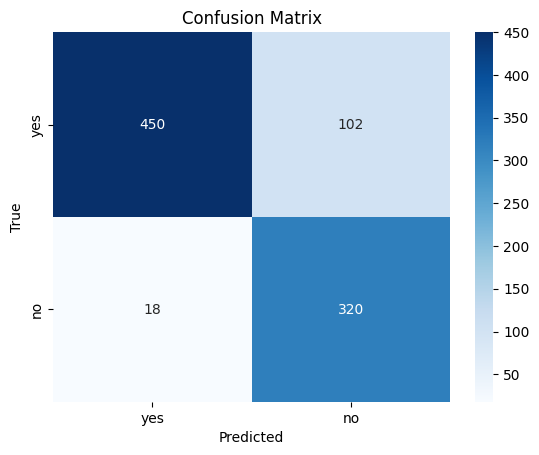

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

predictions_output = trainer.predict(test_dataset)
logits = predictions_output.predictions
labels = predictions_output.label_ids
preds = np.argmax(logits, axis=1)

print("Classification Report:")
print(classification_report(labels, preds, target_names=['yes', 'no']))

cm = confusion_matrix(labels, preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['yes', 'no'],
            yticklabels=['yes', 'no'])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()